In [1]:
import os, sys
import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input, Merge, Dropout
from keras.layers import BatchNormalization
from keras.optimizers import SGD, Adam, Adamax
from keras.models import model_from_yaml
from keras.regularizers import l1, l2
from load_dataset import get_data, dataset
from utils import print_metadata, get_dgaze_frames_count, split_data, plot_gaze_points, save_model, load_model

from sklearn import preprocessing
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import pandas as pd
import copy
import cv2 

from numpy.random import seed
seed(33)

from tensorflow import set_random_seed
set_random_seed(26)

import random 
random.seed(10)

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

# from keras import backend as k
# import tensorflow as tf
# config = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1,
# allow_soft_placement=True, device_count = {'CPU': 1})
# sess = tf.Session(graph=tf.get_default_graph(),config=config)
# k.set_session(sess)

import warnings
warnings.filterwarnings("ignore")

Using TensorFlow backend.


In [2]:
data_path = '/ssd_scratch/cvit/isha/eye_gaze_mapping/DGM_final2/dataset_samples_callibrated/'
model_save = '/ssd_scratch/cvit/isha/DGAZE2/DGAZE_weights/weights_proposed_approach_lefteye'
drivers = os.listdir(data_path)
ndrivers = len(drivers)
sequences = 112

# Driver_data is dict contatining drivers user1, user 2.....etc. For each driver, we have 112 sequences and for   
# each sequence we have features like ['face_location', 'headpose_pupil', 'left_eye', 'gaze_point', 'right_eye'] 
driver_data = get_data(data_path, drivers, sequences)

# Print the total numer of frames in the dataset
get_dgaze_frames_count(driver_data, drivers)

# Prints the DGAZE Metadata including list of drivers, sequences and features 
#print_metadata(driver_data, ['drivers', 'sequences', 'features'])
print_metadata(driver_data, ['features'])

100%|██████████| 20/20 [00:16<00:00,  1.17it/s]


Total frames in DGAZE dataset is 227178
List of Features: ['face_location', 'gaze_point', 'left_eye', 'right_eye', 'headpose_pupil']



In [3]:
seq_range = np.arange(10, sequences+1)
nsequences = len(seq_range)
ndrivers = len(drivers)
random.shuffle(drivers)

dsplit = [int(0.8*ndrivers),int(0.1*ndrivers), int(0.1*ndrivers)]
gp_split = [int(0.6*nsequences),int(0.2*nsequences), int(0.2*nsequences)]
data_split = split_data(drivers, seq_range, dsplit, gp_split)

In [4]:
data_split

{'drivers_test': ['user17', 'user19'],
 'drivers_train': ['user24',
  'user23',
  'user22',
  'user12',
  'user18',
  'user2',
  'user8',
  'user13',
  'user5',
  'user3',
  'user10',
  'user21',
  'user16',
  'user11',
  'user14',
  'user15'],
 'drivers_val': ['user20', 'user7'],
 'sequence_test': array([ 84,  15, 109,  88,  66,  40, 104, 112,  56,  94,  48,  97,  32,
         68,  43,  96,  46,  63,  58,  55]),
 'sequence_train': array([ 49, 102,  28,  83,  26, 108,  57,  79,  11,  39, 105,  93,  91,
         95,  45,  90,  53,  23,  82,  81,  61, 110,  35,  75,  31,  60,
         42,  24,  77,  13,  47,  21,  54, 100,  85,  76,  71,  37, 103,
         22,  20,  73,  16,  17,  59,  64,  33, 107, 111,  19,  92,  44,
         14,  52,  86,  62,  29,  41,  69,  12,  25]),
 'sequence_val': array([ 36,  72,  38,  30,  74,  51,  18,  70,  65,  67,  80,  50,  89,
         99,  78, 101,  34,  98, 106,  10])}

In [5]:
# Training dataset
train = dataset(driver_data, data_split['drivers_train'], data_split['sequence_train'])

# Validation dataset
val = dataset(driver_data, data_split['drivers_val'], data_split['sequence_val'])

# Test dataset
test = dataset(driver_data, data_split['drivers_test'], data_split['sequence_test'])

100%|██████████| 2/2 [00:00<00:00,  7.73it/s]


In [6]:
print(train['left_eye'].shape, train['right_eye'].shape, train['headpose_pupil'].shape, \
      train['face_location'].shape, train['face_features'].shape, train['gaze_point'].shape)

print(val['left_eye'].shape, val['right_eye'].shape, val['headpose_pupil'].shape, \
      val['face_location'].shape, val['face_features'].shape, val['gaze_point'].shape)

print(test['left_eye'].shape, test['right_eye'].shape, test['headpose_pupil'].shape, \
      test['face_location'].shape, test['face_features'].shape, test['gaze_point'].shape)

print("Total number of frames -->",train['gaze_point'].shape[0] + val['gaze_point'].shape[0]\
      + test['gaze_point'].shape[0])

(98306, 36, 60, 3) (98306, 36, 60, 3) (98306, 11) (98306, 4) (98306, 14) (98306, 6)
(4779, 36, 60, 3) (4779, 36, 60, 3) (4779, 11) (4779, 4) (4779, 14) (4779, 6)
(3761, 36, 60, 3) (3761, 36, 60, 3) (3761, 11) (3761, 4) (3761, 14) (3761, 6)
Total number of frames --> 106846


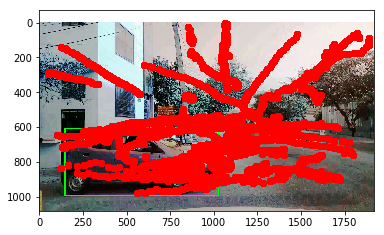

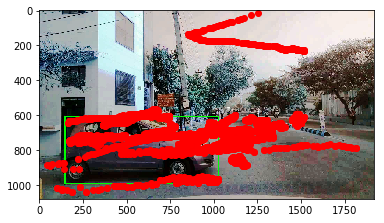

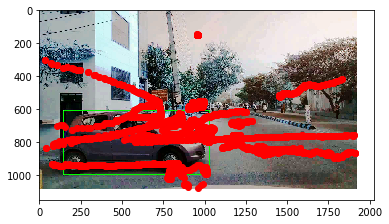

In [7]:
plot_gaze_points(data_path, train['gaze_point'])
plot_gaze_points(data_path, val['gaze_point'])
plot_gaze_points(data_path, test['gaze_point'])

100%|██████████| 1/1 [00:00<00:00, 305.69it/s]


[-9.2135996e-01  5.1466241e+00  2.3130486e+01  3.0200000e+02
  4.7200000e+02  1.5400000e+02  4.8300000e+02  1.0017000e+05
  1.9300000e+02  5.9300000e+02  2.3300000e+02  8.1800000e+02
  0.0000000e+00  5.1800000e+02]


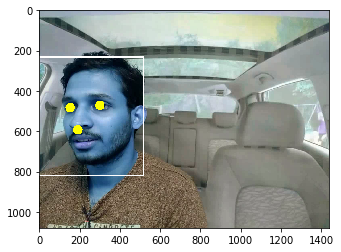

100%|██████████| 1/1 [00:00<00:00, 330.03it/s]


[3.4561303e+00 1.4518099e+00 1.6582497e+01 4.9800000e+02 4.8400000e+02
 3.5100000e+02 4.8300000e+02 9.0258000e+04 4.0700000e+02 5.8400000e+02
 2.8400000e+02 8.0500000e+02 1.7700000e+02 6.9800000e+02]


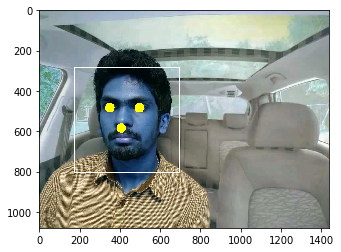

In [8]:
for d in data_split['drivers_val']:
    data_calibrate = dataset(driver_data, [d], np.arange(12,13))
    x = data_calibrate['face_location']
    y = data_calibrate['headpose_pupil']
    print(data_calibrate['face_features'][0])

    cap = cv2.VideoCapture(data_path + d + '/driver_view/sample_10.avi')
    ret, frame = cap.read()
    plt.figure()
    cv2.rectangle(frame, (x[0,2], x[0,0]), (x[0,3], x[0,1]), (255, 255, 255), 6)
    cv2.circle(frame,(int(y[0,6]), int(y[0,7])),3,(255,255,0),40)
    cv2.circle(frame,(int(y[0,4]), int(y[0,5])),3,(255,255,0),40)
    cv2.circle(frame,(int(y[0,9]), int(y[0,10])),3,(255,255,0),40)
    plt.imshow(frame)
    plt.show()

In [9]:
# scaler = preprocessing.MinMaxScaler()
# train['face_features'] = scaler.fit_transform(train['face_features'])
# val['face_features'] = scaler.transform(val['face_features'])
# test['face_features'] = scaler.transform(test['face_features'])


In [58]:
model_lefteye = Sequential()
model_lefteye.add(Conv2D(20, kernel_size=(3, 3),activation='relu',input_shape=(36,60,3)))
model_lefteye.add(MaxPooling2D(pool_size=(2, 2)))
model_lefteye.add(Dropout(0.5))
model_lefteye.add(Conv2D(50, (3, 3), activation='relu'))
model_lefteye.add(MaxPooling2D(pool_size=(2, 2)))
model_lefteye.add(Flatten())


# model_facefeatures = Sequential()
# model_facefeatures.add(Dense(16, activation ='relu', input_dim=(14)))

# model_merge = Sequential()
# model_merge.add(Merge([model_lefteye, model_facefeatures], mode = 'concat'))
model = model_lefteye
model.add(Dense(500, activation='relu'))
#model_merge.add(Dense(256, activation='relu', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
model.add(Dense(2, activation="linear"))
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 34, 58, 20)        560       
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 17, 29, 20)        0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 17, 29, 20)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 15, 27, 50)        9050      
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 7, 13, 50)         0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 4550)              0         
_________________________________________________________________
dense_15 (Dense)             (None, 500)               2275500   
__________

In [59]:
opt = Adam(lr=0.01, decay=0.1 / 200)
model.compile(loss = 'mae', optimizer = opt )
earlystopping = keras.callbacks.EarlyStopping(monitor = 'val_loss',min_delta = 1, patience =10, verbose =0, mode ='auto')

history = model.fit([train['left_eye']], train['gaze_point'][:,:2], \
                validation_data= ([val['left_eye']],val['gaze_point'][:,:2]),
                epochs = 200, batch_size = 32,  callbacks =[earlystopping], verbose=1, shuffle= True)

save_model(model_save, model)

print(history.history.keys())

Train on 98306 samples, validate on 4779 samples
Epoch 1/200
98306/98306 [==============================] - 53s 540us/step - loss: 196.5622 - val_loss: 506.7657
Epoch 2/200
98306/98306 [==============================] - 37s 371us/step - loss: 170.8641 - val_loss: 402.8820
Epoch 3/200
98306/98306 [==============================] - 38s 384us/step - loss: 159.3341 - val_loss: 383.7603
Epoch 4/200
98306/98306 [==============================] - 42s 428us/step - loss: 152.9660 - val_loss: 321.5542
Epoch 5/200
98306/98306 [==============================] - 58s 589us/step - loss: 148.7661 - val_loss: 336.0305
Epoch 6/200
98306/98306 [==============================] - 59s 597us/step - loss: 145.7424 - val_loss: 293.4126
Epoch 7/200
98306/98306 [==============================] - 59s 596us/step - loss: 142.9566 - val_loss: 294.7700
Epoch 8/200
98306/98306 [==============================] - 58s 588us/step - loss: 141.1553 - val_loss: 302.0819
Epoch 9/200
98306/98306 [==============================

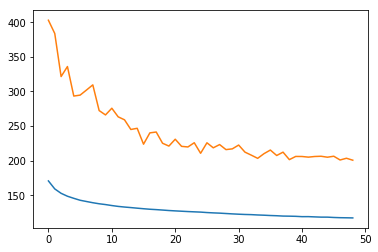

In [60]:
plt.plot(history.history['loss'][1:])
plt.plot(history.history['val_loss'][1:])
plt.show()

In [61]:
save_model(model_save, model)

print(history.history.keys())

Saved model to disk
dict_keys(['loss', 'val_loss'])


In [62]:
def gaze_error(model, data):
    scores = model.evaluate([data['left_eye']], data['gaze_point'][:,:2])
    return scores


In [63]:
model = load_model(model_save)
model.compile(loss='mae', optimizer=opt)

train_error = gaze_error(model, train)
val_error = gaze_error(model, val)
test_error = gaze_error(model, test)
    
print("Train Error ==> ", train_error)
print("Val Error ==> ",  val_error)
print("Test Error ==> " ,test_error)

Loaded model from disk
3761/3761 [==============================] - 0s 66us/step
Train Error ==>  151.07965371006927
Val Error ==>  200.78414705623317
Test Error ==>  202.60937277670396


In [64]:
# for driver in data_split['drivers_test']:

#     data_calibrate = dataset(driver_data, [driver], np.arange(1,113))
#     model_merge = load_model(model_save)
    
#     opt = Adam(lr=0.001, decay=0.1 / 200)
#     model_merge.compile(loss='mae', optimizer=opt)
#     scores = model_merge.evaluate([data_calibrate['left_eye'][2000:], data_calibrate['face_features'][2000:]], data_calibrate['gaze_point'][2000:,:2])
#     print("====> Before Calibration", scores)                   

#     history = model_merge.fit([data_calibrate['left_eye'][:2000], data_calibrate['face_features'][:2000]], data_calibrate['gaze_point'][:2000,:2], \
#                     validation_data= ([data_calibrate['left_eye'][2000:], data_calibrate['face_features'][2000:]],data_calibrate['gaze_point'][2000:,:2]),
#                     epochs = 20, batch_size = 32, verbose=1, shuffle= True)

#     scores = model_merge.evaluate([data_calibrate['left_eye'][2000:], data_calibrate['face_features'][2000:]], data_calibrate['gaze_point'][2000:,:2])

#     print("====> After Calibration", scores) 

In [67]:
te_error = 0; tr_error = 0
for driver in data_split['drivers_val']:
    data_calibrate = dataset(driver_data, [driver], np.arange(1,15))
                         
    te_calibrate = dataset(driver_data, [driver], data_split['sequence_val'])

    print(te_calibrate['gaze_point'].shape)
    opt = Adam(lr=0.0001, decay=0.1 / 200)
    
    model_merge = load_model(model_save)
    for layer in model_merge.layers[:1]:
        layer.trainable = False
        
    model_merge.compile(loss = 'mae', optimizer = opt)
    
    error = gaze_error(model_merge, te_calibrate)
    tr_error += error
    print("Test Error ==> " ,error)
              

        
    model_merge.fit([data_calibrate['left_eye']], data_calibrate['gaze_point'][:,:2], \
                validation_data= ([te_calibrate['left_eye']],te_calibrate['gaze_point'][:,:2]),
                epochs = 10, batch_size = 8, callbacks = [earlystopping], verbose=1, shuffle= True)


    error = gaze_error(model_merge, te_calibrate)
    te_error += error
    print("Test Error ==> " ,error)
                         
print("Total test error -->", tr_error/len(data_split['drivers_val']), te_error/len(data_split['drivers_val']))
                         
    

100%|██████████| 1/1 [00:00<00:00,  2.54it/s]


(2480, 6)
Loaded model from disk
2480/2480 [==============================] - 3s 1ms/step
Test Error ==>  199.0787852133474
Train on 1316 samples, validate on 2480 samples
Epoch 1/10
1316/1316 [==============================] - 10s 8ms/step - loss: 204.8219 - val_loss: 203.9039
Epoch 2/10
1316/1316 [==============================] - 4s 3ms/step - loss: 168.2694 - val_loss: 207.1680
Epoch 3/10
1316/1316 [==============================] - 4s 3ms/step - loss: 154.7737 - val_loss: 201.5529
Epoch 4/10
1316/1316 [==============================] - 4s 3ms/step - loss: 146.0427 - val_loss: 202.8403
Epoch 5/10
1316/1316 [==============================] - 4s 3ms/step - loss: 142.5599 - val_loss: 196.7842
Epoch 6/10
1316/1316 [==============================] - 4s 3ms/step - loss: 137.7045 - val_loss: 194.7990
Epoch 7/10
1316/1316 [==============================] - 4s 3ms/step - loss: 135.3278 - val_loss: 196.1566
Epoch 8/10
1316/1316 [==============================] - 4s 3ms/step - loss: 134.4115 

100%|██████████| 1/1 [00:00<00:00,  2.26it/s]


(2299, 6)
Loaded model from disk
2299/2299 [==============================] - 3s 1ms/step
Test Error ==>  202.62377149159622
Train on 1296 samples, validate on 2299 samples
Epoch 1/10
1296/1296 [==============================] - 10s 8ms/step - loss: 202.0691 - val_loss: 182.5487
Epoch 2/10
1296/1296 [==============================] - 4s 3ms/step - loss: 128.6608 - val_loss: 172.4698
Epoch 3/10
1296/1296 [==============================] - 4s 3ms/step - loss: 99.4943 - val_loss: 175.7960
Epoch 4/10
1296/1296 [==============================] - 4s 3ms/step - loss: 90.3651 - val_loss: 177.9754
Epoch 5/10
1296/1296 [==============================] - 4s 3ms/step - loss: 84.5893 - val_loss: 175.6754
Epoch 6/10
1296/1296 [==============================] - 4s 3ms/step - loss: 81.3710 - val_loss: 173.0917
Epoch 7/10
1296/1296 [==============================] - 4s 3ms/step - loss: 76.8011 - val_loss: 168.8228
Epoch 8/10
1296/1296 [==============================] - 4s 3ms/step - loss: 74.1144 - val

In [74]:
te_error = 0; tr_error = 0
for driver in data_split['drivers_test']:
    data_calibrate = dataset(driver_data, [driver], np.arange(1,15))
                         
    te_calibrate = dataset(driver_data, [driver], data_split['sequence_test'])

    print(te_calibrate['gaze_point'].shape)
    
    opt = Adam(lr=0.00001, decay=0.1 / 200)
    
    model_merge = load_model(model_save)
    for layer in model_merge.layers[:1]:
        layer.trainable = False
        
    model_merge.compile(loss = 'mae', optimizer = opt)
    
    error = gaze_error(model_merge, te_calibrate)
    tr_error += error
    print("Test Error ==> " ,error)
              

        
    model_merge.fit([data_calibrate['left_eye']], data_calibrate['gaze_point'][:,:2], \
                validation_data= ([te_calibrate['left_eye']],te_calibrate['gaze_point'][:,:2]),
                epochs = 10, batch_size = 16, verbose=1, shuffle= True)


    error = gaze_error(model_merge, te_calibrate)
    te_error += error
    print("Test Error ==> " ,error)
                         
print("Total test error -->", tr_error/len(data_split['drivers_test']), te_error/len(data_split['drivers_val']))
                         
    

100%|██████████| 1/1 [00:00<00:00, 19.66it/s]


(1743, 6)
Loaded model from disk
1743/1743 [==============================] - 1s 447us/step
Test Error ==>  199.02228903319053
Train on 1291 samples, validate on 1743 samples
Epoch 1/10
1291/1291 [==============================] - 2s 2ms/step - loss: 222.2658 - val_loss: 200.1753
Epoch 2/10
1291/1291 [==============================] - 1s 460us/step - loss: 215.7126 - val_loss: 201.4987
Epoch 3/10
1291/1291 [==============================] - 1s 461us/step - loss: 209.4400 - val_loss: 203.2376
Epoch 4/10
1291/1291 [==============================] - 1s 460us/step - loss: 204.1023 - val_loss: 205.2701
Epoch 5/10
1291/1291 [==============================] - 1s 462us/step - loss: 199.9199 - val_loss: 207.2666
Epoch 6/10
1291/1291 [==============================] - 1s 464us/step - loss: 193.4588 - val_loss: 209.3125
Epoch 7/10
1291/1291 [==============================] - 1s 460us/step - loss: 190.2861 - val_loss: 211.2153
Epoch 8/10
1291/1291 [==============================] - 1s 461us/step -

  0%|          | 0/20 [00:00<?, ?it/s]

Test Error ==>  216.41650939958916


100%|██████████| 1/1 [00:00<00:00, 13.18it/s]


(2018, 6)
Loaded model from disk
2018/2018 [==============================] - 1s 385us/step
Test Error ==>  205.70763092494695
Train on 1317 samples, validate on 2018 samples
Epoch 1/10
1317/1317 [==============================] - 2s 2ms/step - loss: 258.8911 - val_loss: 202.1537
Epoch 2/10
1317/1317 [==============================] - 1s 480us/step - loss: 252.0711 - val_loss: 199.4427
Epoch 3/10
1317/1317 [==============================] - 1s 480us/step - loss: 243.1792 - val_loss: 198.2417
Epoch 4/10
1317/1317 [==============================] - 1s 480us/step - loss: 236.9698 - val_loss: 197.1500
Epoch 5/10
1317/1317 [==============================] - 1s 480us/step - loss: 232.8050 - val_loss: 197.2810
Epoch 6/10
1317/1317 [==============================] - 1s 479us/step - loss: 225.6309 - val_loss: 197.5664
Epoch 7/10
1317/1317 [==============================] - 1s 480us/step - loss: 222.9734 - val_loss: 197.5563
Epoch 8/10
1317/1317 [==============================] - 1s 479us/step -